<a href="https://colab.research.google.com/github/velozo27/TCC-Pedro-Velozo-ENG1132/blob/change-how-image-files-are-retrieved/SRCNN_Comentada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports e definição de Constantes

In [1]:
try:
    from google.colab import files
    from google.colab import drive
    drive.mount("/content/gdrive")
    DATASET_ROOT="/content/gdrive/MyDrive/TCC/datasets"
    !pip install patchify
    # wandb to log system metrics: (check CPU and GPU usage while session is runnig)
    !pip install wandb
    import wandb
    wandb.init()
    
    import save_model_helper

except ModuleNotFoundError:
    DATASET_ROOT="./datasets/"
    # coloquei as dependencias em um arquivo separado
    !pip install -r requirements.txt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.io import read_image
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import numpy as np
from datetime import datetime
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from torchvision.transforms import Compose, ToTensor, Resize
import pandas as pd
import time
import re
from pathlib import Path
import image_patches
import image_helper
import load_model_helper


DATASET_NAME = "Flickr2K"
# DATASET_NAME = "Set14"

# Mudar aqui se for para treinar salvando os dataframes e epochs no drive
# Se True, não pega nem salva nada no drive
EXPERIMENTAL_MODE = True


# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
# garantir que é cuda
# assert device == "cuda"

# https://stackoverflow.com/questions/65734044/kernel-appears-to-have-died-jupyter-notebook-python-matplotlib
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# https://stackoverflow.com/a/74952995
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"


  Using cached opencv_python-4.8.0.74-cp37-abi3-macosx_11_0_arm64.whl (33.1 MB)


/Users/pedrovelozo/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Criando os patches

(patches já foram criados, não precisa rodar)

In [3]:
%time
# otimizacao: criar patches de treino, validacao e teste de uma vez: (32, 8, 2)
image_patches.create_valid_image_patches(f"{DATASET_ROOT}/{DATASET_NAME}", (33, 33, 3), f"{DATASET_ROOT}/{DATASET_NAME}_train", 150)
# image_patches.create_image_patches(f"{DATASET_ROOT}/{DATASET_NAME}", (33, 33, 3), f"{DATASET_ROOT}/{DATASET_NAME}_validation", 25)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


  0%|          | 0/2651 [00:00<?, ?it/s]

100%|██████████| 2651/2651 [05:53<00:00,  7.50it/s]


# ***SRCNN***

In [16]:
class SRCNN(nn.Module):
    def __init__(self, num_channels=3, use_padding=True, initialization='normal'):
        super(SRCNN, self).__init__()
        self.initialization = initialization
        self.using_padding = use_padding
        padding = [0, 0, 0]
        if use_padding:
            padding = [9 // 2, 5 // 2, 5 // 2]
        # self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=9, padding=padding[0])
        # self.conv2 = nn.Conv2d(64, 32, kernel_size=5, padding=padding[1])
        # self.conv3 = nn.Conv2d(32, num_channels, kernel_size=5, padding=padding[2])

        self.conv1 = nn.Conv2d(
            3, 64, kernel_size=9, stride=(1, 1), padding=(2, 2)
        )
        self.conv2 = nn.Conv2d(
            64, 32, kernel_size=1, stride=(1, 1), padding=(2, 2)
        )
        self.conv3 = nn.Conv2d(
            32, 3, kernel_size=5, stride=(1, 1), padding=(2, 2)
        )

        self.relu = nn.ReLU(inplace=True)
        
        # self.apply(self._init_weights)
        # self._init_weights()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x
    
    def _init_weights(self):
      # The filter weights of each layer are initialized by drawing randomly 
      # from a Gaussian distribution with zero mean and standard deviation 0.001 (and 0 for biases)
      for module in self.modules():
        if isinstance(module, nn.Conv2d):
          if self.initialization == "normal":
            module.weight.data.normal_(mean=0.0, std=0.001)
          elif self.initialization == "xavier":
            nn.init.xavier_normal_(module.weight.data)
          else:
            nn.init.eye_(module.weight.data)

          if module.bias is not None:
              module.bias.data.zero_()


In [17]:
model_test = SRCNN(num_channels=3)

input_1 = torch.randn([3, 33, 33])
print(input_1.shape)

output_1 = model_test(input_1)
print(output_1.shape)

torch.Size([3, 33, 33])
torch.Size([3, 33, 33])


# Loops de **Treino** e **Validação**

In [5]:
def train_loop(dataloader, model, loss_fn, optimizer, device="cuda" if torch.cuda.is_available() else "cpu"):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    print(f"Training on {size} samples...")
    print("Batch size:", dataloader.batch_size)
    print("Number of batches:", num_batches)

    train_loss = 0
    for batch, (X, y) in tqdm(enumerate(dataloader), total=len(dataloader)):
        # X = X.to(device)
        # print("X", X.shape, X.get_device())
        # y = y.to(device)
        # Compute prediction and loss
        pred = model(X)
        # print(pred.shape, pred.get_device())
        loss = loss_fn(pred, y)

        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_loss /= num_batches

    # return avg loss
    print(f"Training Error: \n Avg loss: {train_loss:>8f} \n")
    return train_loss

# will also be used for testing (maybe)
def validation_loop(dataloader, model, loss_fn, device="cuda" if torch.cuda.is_available() else "cpu"):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    validation_loss = 0

    with torch.no_grad(), tqdm(total=num_batches) as progress_bar:
        for X, y in dataloader:
            # X = X.to(device)
            # y = y.to(device)
            pred = model(X)
            validation_loss += loss_fn(pred, y).item()
            progress_bar.update(1)

    validation_loss /= num_batches

    print(f"Validation Error: \n Avg loss: {validation_loss:>8f} \n")
    return validation_loss


# CustomImageDataset

In [7]:
class CustomImageDataset(Dataset):
    """
    A PyTorch dataset for loading a directory of images.

    Args:
        img_dir (str): The path to the directory containing the images.
        transform (callable, optional): A function/transform that takes in an image and returns a
            transformed version. Default: None.
        target_transform (callable, optional): A function/transform that takes in the target and
            transforms it. Default: None.
    """

    def __init__(self, img_dir: str, patches_per_image = None | int, transform = None, target_transform = None, use_patches = True, device="cuda" if torch.cuda.is_available() else "cpu" ):
        """
        Initializes a new instance of the CustomImageDataset class.

        Args:
            img_dir (str): The path to the directory containing the images.
            transform (callable, optional): A function/transform that takes in an image and returns a
                transformed version. Default: None.
            target_transform (callable, optional): A function/transform that takes in the target and
                transforms it. Default: None.
        """
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.patches_per_image = patches_per_image
        self.device = device
        
        self.file_list_tensor = self.create_tensors_from_images()
        self.file_list_tensor.to(device)

    def create_tensors_from_images(self):
      number_of_images = self._get_number_of_images_in_folder(f"{self.img_dir}/patches")

      # creating the empty tensor
      image_tensors = torch.empty((number_of_images, 3, 33, 33))

      current_tensor_index = 0

      all_patches_dir = f"{self.img_dir}/patches"
      if not os.path.exists(all_patches_dir) or not os.path.isdir(all_patches_dir):
          return list(os.listdir(self.img_dir))

      for patch_path in tqdm(list(os.listdir(all_patches_dir))):
        one_patch_full_dir = f"{all_patches_dir}/{patch_path}"
        one_path_relative_dir = f"patches/{patch_path}"
        
        patches_list = list(os.listdir(one_patch_full_dir))
        
        for index, patch in enumerate(patches_list):
          image_path = f"{one_path_relative_dir}/{patch}"

          if self._check_if_image_is_not_corrupted(image_path):
            continue
          
          image_as_tensor = read_image(f"{self.img_dir}/{image_path}")

          # updating the created tensor
          image_tensors[current_tensor_index] = image_as_tensor.float() / 255

          current_tensor_index += 1
                    
      return image_tensors


    def __len__(self) -> int:
        """
        Returns the number of images in the dataset.

        Returns:
            The number of images in the dataset.
        """
        return self._get_number_of_images_in_folder(f"{self.img_dir}/patches")

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Returns the image at the specified index in the dataset.

        Args:
            idx (int): The index of the image to return.

        Returns:
            A tuple containing the transformed input image and the transformed target image.
        """
    
        image = self.file_list_tensor[idx]
        # image_x = image.detach().clone()
        # image_y = image.detach().clone()

        image_x = image.to(self.device)
        image_y = image.to(self.device)
        
        if self.transform:
            # image_x = self.transform(image_x)
            image_x = self.transform(image)
            # image_x = self.transform(image).to(device)
        if self.target_transform:
            #image_y = self.target_transform(image_y)
            image_y = self.target_transform(image)
            # image_y = self.target_transform(image).to(device)
            
          
        return image_x.to(self.device), image_y.to(self.device)

    def _get_number_of_images_in_folder(self, dir: str):
      """
      Gets the total number of all the patches
      """
      all_patches_dir = f"{self.img_dir}/patches"
      if not os.path.exists(all_patches_dir) or not os.path.isdir(all_patches_dir):
          return list(os.listdir(self.img_dir))

      number_of_images = 0
      for patch_path in list(os.listdir(all_patches_dir)):
        one_patch_full_dir = f"{all_patches_dir}/{patch_path}"
        one_path_relative_dir = f"patches/{patch_path}"
        
        patches_list = list(os.listdir(one_patch_full_dir))
        
        for index, patch in enumerate(patches_list):
          image_path = f"{one_path_relative_dir}/{patch}"

          if self._check_if_image_is_not_corrupted(image_path):
            continue

          number_of_images += 1

      return number_of_images

    def _check_if_image_is_not_corrupted(self, image_path: str) -> bool:
      """
      Returns True if the file is corrupted else returns False
      """
      file_size = Path(f"{self.img_dir}/{image_path}").stat().st_size

      if file_size == 0:
        print(f"Error loading image file: {self.img_dir}/{image_path}. Reason: file has size 0")
        return True
      
      return False

# Criando os ***Dataset*'s**

In [7]:
%%time
transform_x = transforms.Compose([
    # downscale by factor of 3 (from 33x33 to 11x11 back to 33x33)
    # resize image to 11x11 and downsample by BICUBIC interpolation
    transforms.Resize((11, 11), interpolation=Image.BICUBIC),
    # resize image to 33x33
    transforms.Resize((33, 33), interpolation=Image.BICUBIC)
    # transforms.CenterCrop((33, 33))
])

transform_y = transforms.Compose([
    ##transforms.Resize((33, 33), interpolation=Image.BICUBIC)
    #transforms.CenterCrop((21, 21))
    transforms.CenterCrop((17, 17))
    # transforms.CenterCrop((25, 25))
    # transforms.CenterCrop((33, 33))
])

# Set up the data loaders
train_data_set = CustomImageDataset(
    img_dir=f"{DATASET_ROOT}/{DATASET_NAME}_train", transform=transform_x, target_transform=transform_y)
validation_data_set = CustomImageDataset(
    img_dir=f"{DATASET_ROOT}/{DATASET_NAME}_validation", transform=transform_x, target_transform=transform_y)

# # Report split sizes
print('Training set has {} instances'.format(len(train_data_set)))
print('Validation set has {} instances'.format(len(validation_data_set)))

100%|██████████| 2650/2650 [01:07<00:00, 39.16it/s]


Training set has 188150 instances
Validation set has 66250 instances
CPU times: total: 1min 18s
Wall time: 6min 1s


In [8]:
%%time

# https://towardsdatascience.com/7-tips-for-squeezing-maximum-performance-from-pytorch-ca4a40951259
pin_memory = False
batch_size = round(0.75*(2**13))
# batch_size = 2**13

train_dataloader = DataLoader(train_data_set, batch_size=batch_size, shuffle=True, pin_memory=pin_memory) # TODO: aumentar batch_size p/ 2^12
validation_dataloader = DataLoader(validation_data_set, batch_size=batch_size, pin_memory=pin_memory)

CPU times: total: 21.3 s
Wall time: 28.7 s


In [9]:
# save dataloader (https://discuss.pytorch.org/t/how-to-save-dataloader/62813/4)
# torch.save(train_dataloader, 'train_dataloader.pth')
# torch.save(train_dataloader, 'validation_dataloader.pth')

# Instanciando o modelo

In [10]:
# Instancianting the model
# Atencao: cuidado ao rodar o treino várias vezes sem resetar o modelo!
# model = SRCNN(initialization="normal")
# model.to(device)

In [11]:
model = SRCNN(num_channels=3)
model.to(device)

SRCNN(
  (conv1): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv2): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU(inplace=True)
)

In [12]:
# img = image_patches.get_image_patch(f"{DATASET_ROOT}/{DATASET_NAME}_train").float()/255
# print(type(img), img.shape, img.dtype, img.min(), img.max())
# with torch.no_grad():
#   img_out = model(img.unsqueeze(0).to(device))
# print(type(img_out), img_out.shape, img_out.dtype, img_out.min(), img_out.max())
# # plt.figure()
# # plt.subplot(1, 2, 1)
# # plt.imshow(ImageHelperInstance.tensor_as_image(img.cpu()))
# # plt.subplot(1, 2, 2)
# # plt.imshow(ImageHelperInstance.tensor_as_image(img_out.squeeze().cpu()))
# # plt.show()

In [13]:
# plt.figure()
# plt.subplot(1, 2, 1)
# plt.imshow(image_helper.tensor_as_image(img.cpu()))
# plt.subplot(1, 2, 2)
# plt.imshow(image_helper.tensor_as_image(img_out.squeeze().cpu()))
# plt.show()

# Criando o *Optmizer* e a *loss function* (MSE)

In [19]:
# otimizacao: Mudar o otimizador para Adam ou RMSProp
#           : Usar momentum = 0.9
#           : Usar learning maior: 1e-4?
#           : Usar learning rate decay

# hyperparameters
#https://stackoverflow.com/questions/48324152/pytorch-how-to-change-the-learning-rate-of-an-optimizer-at-any-given-moment-no
lr = 1e-4
model = SRCNN(num_channels=3, use_padding=False)
model.to(device)
# 3.3 Training
# The loss is minimized using stochastic gradient descent with the standard backpropagation
# optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer,
#     mode='min',
#     factor=0.1,
#     patience=2,
#     threshold=1e-3,
#     verbose=True
#     )
scheduler = torch.optim.lr_scheduler.LinearLR(
    optimizer,
    start_factor=1.0,
    end_factor=0.1,
    total_iters=20)
# we use Mean Squared Error (MSE) as the loss function:
loss_fn = nn.MSELoss()
loss_fn.to(device)

MSELoss()

# **Treinamento** 

## Execução das *epochs*
- Execução dos loops de treinamento e validação, e também salvamentos dos dados

In [20]:
# starting_epoch = load_model_helper.get_epoch_number_from_path(model_load_path_name)
# if starting_epoch is not None:
#   starting_epoch = starting_epoch + 1 # add 1 because we are starting after the epoch we left of
# print('starting_epoch =', starting_epoch)
starting_epoch = 0


In [21]:
%%time
train_loss = 0
validation_loss =0
epochs = 20

######
epoch_array = []
time_array = []
lr_array = []
######

# melhor usar lista e depois converter para array
train_loss_array = list()
validation_loss_array = list()
for index, t in enumerate(range(epochs)):
    current_epoch = load_model_helper.get_current_epoch(index, t, starting_epoch)
    
    print(f"\nepoch {current_epoch}\n-------------------------------")

    start_time = time.time()  # Start timing the epoch

    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    validation_loss = validation_loop(validation_dataloader, model, loss_fn)

    # changes the learning rate when the validation loss stops decreasing
    #scheduler.step(validation_loss)
    print(f"Learning rate (antes): {optimizer.param_groups[0]['lr']}")
    scheduler.step()
    print(f"Learning rate (depois): {optimizer.param_groups[0]['lr']}")
    
    train_loss_array.append(train_loss)
    validation_loss_array.append(validation_loss)

    elapsed_time = time.time() - start_time  # Calculate elapsed time for the epoch
    
    ######
    epoch_array.append(current_epoch)
    time_array.append(elapsed_time)
    lr_array.append(optimizer.param_groups[0]['lr'])
    ######
    
    # updating learning rate
    # if current_epoch % 10 == 0 and current_epoch > 0:
    #     optimizer.param_groups[0]['lr'] /= 2

    if not EXPERIMENTAL_MODE:
      df_path = '/content/gdrive/My Drive/TCC/code/models/SRCNN/testing/train_session_testing/SRCNN_train_vs_validation_loss.csv'
      save_model_helper.save_df(df_path, train_loss, validation_loss, current_epoch, elapsed_time)
      save_model_helper.save_epoch(current_epoch, train_loss, validation_loss)
    
print("Done!")


epoch 0
-------------------------------
Training on 188150 samples...
Batch size: 6144
Number of batches: 31


  0%|          | 0/31 [00:00<?, ?it/s]C:\Users\Pedro\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 31/31 [05:32<00:00, 10.73s/it]


Training Error: 
 Avg loss: 0.068199 



100%|██████████| 11/11 [01:16<00:00,  6.94s/it]


Validation Error: 
 Avg loss: 0.016732 

Learning rate (antes): 0.0001
Learning rate (depois): 9.55e-05

epoch 1
-------------------------------
Training on 188150 samples...
Batch size: 6144
Number of batches: 31


100%|██████████| 31/31 [06:00<00:00, 11.64s/it]


Training Error: 
 Avg loss: 0.009179 



100%|██████████| 11/11 [00:57<00:00,  5.18s/it]


Validation Error: 
 Avg loss: 0.006412 

Learning rate (antes): 9.55e-05
Learning rate (depois): 9.1e-05

epoch 2
-------------------------------
Training on 188150 samples...
Batch size: 6144
Number of batches: 31


100%|██████████| 31/31 [05:27<00:00, 10.57s/it]


Training Error: 
 Avg loss: 0.005400 



100%|██████████| 11/11 [00:55<00:00,  5.05s/it]


Validation Error: 
 Avg loss: 0.004612 

Learning rate (antes): 9.1e-05
Learning rate (depois): 8.65e-05

epoch 3
-------------------------------
Training on 188150 samples...
Batch size: 6144
Number of batches: 31


100%|██████████| 31/31 [05:32<00:00, 10.71s/it]


Training Error: 
 Avg loss: 0.004221 



100%|██████████| 11/11 [01:00<00:00,  5.52s/it]


Validation Error: 
 Avg loss: 0.003999 

Learning rate (antes): 8.65e-05
Learning rate (depois): 8.2e-05

epoch 4
-------------------------------
Training on 188150 samples...
Batch size: 6144
Number of batches: 31


100%|██████████| 31/31 [05:00<00:00,  9.71s/it]


Training Error: 
 Avg loss: 0.003848 



100%|██████████| 11/11 [00:53<00:00,  4.89s/it]


Validation Error: 
 Avg loss: 0.003769 

Learning rate (antes): 8.2e-05
Learning rate (depois): 7.75e-05

epoch 5
-------------------------------
Training on 188150 samples...
Batch size: 6144
Number of batches: 31


100%|██████████| 31/31 [05:05<00:00,  9.87s/it]


Training Error: 
 Avg loss: 0.003679 



100%|██████████| 11/11 [00:52<00:00,  4.78s/it]


Validation Error: 
 Avg loss: 0.003657 

Learning rate (antes): 7.75e-05
Learning rate (depois): 7.3e-05

epoch 6
-------------------------------
Training on 188150 samples...
Batch size: 6144
Number of batches: 31


100%|██████████| 31/31 [04:12<00:00,  8.15s/it]


Training Error: 
 Avg loss: 0.003602 



100%|██████████| 11/11 [00:54<00:00,  4.94s/it]


Validation Error: 
 Avg loss: 0.003601 

Learning rate (antes): 7.3e-05
Learning rate (depois): 6.85e-05

epoch 7
-------------------------------
Training on 188150 samples...
Batch size: 6144
Number of batches: 31


100%|██████████| 31/31 [04:28<00:00,  8.65s/it]


Training Error: 
 Avg loss: 0.003557 



100%|██████████| 11/11 [00:52<00:00,  4.78s/it]


Validation Error: 
 Avg loss: 0.003566 

Learning rate (antes): 6.85e-05
Learning rate (depois): 6.4e-05

epoch 8
-------------------------------
Training on 188150 samples...
Batch size: 6144
Number of batches: 31


100%|██████████| 31/31 [04:19<00:00,  8.36s/it]


Training Error: 
 Avg loss: 0.003527 



100%|██████████| 11/11 [00:53<00:00,  4.87s/it]


Validation Error: 
 Avg loss: 0.003541 

Learning rate (antes): 6.4e-05
Learning rate (depois): 5.9499999999999996e-05

epoch 9
-------------------------------
Training on 188150 samples...
Batch size: 6144
Number of batches: 31


100%|██████████| 31/31 [04:44<00:00,  9.17s/it]


Training Error: 
 Avg loss: 0.003501 



100%|██████████| 11/11 [00:54<00:00,  4.93s/it]


Validation Error: 
 Avg loss: 0.003520 

Learning rate (antes): 5.9499999999999996e-05
Learning rate (depois): 5.5e-05

epoch 10
-------------------------------
Training on 188150 samples...
Batch size: 6144
Number of batches: 31


100%|██████████| 31/31 [04:26<00:00,  8.60s/it]


Training Error: 
 Avg loss: 0.003484 



100%|██████████| 11/11 [00:52<00:00,  4.76s/it]


Validation Error: 
 Avg loss: 0.003504 

Learning rate (antes): 5.5e-05
Learning rate (depois): 5.05e-05

epoch 11
-------------------------------
Training on 188150 samples...
Batch size: 6144
Number of batches: 31


100%|██████████| 31/31 [04:11<00:00,  8.12s/it]


Training Error: 
 Avg loss: 0.003471 



100%|██████████| 11/11 [00:55<00:00,  5.06s/it]


Validation Error: 
 Avg loss: 0.003491 

Learning rate (antes): 5.05e-05
Learning rate (depois): 4.6e-05

epoch 12
-------------------------------
Training on 188150 samples...
Batch size: 6144
Number of batches: 31


100%|██████████| 31/31 [04:47<00:00,  9.27s/it]


Training Error: 
 Avg loss: 0.003459 



100%|██████████| 11/11 [00:52<00:00,  4.81s/it]


Validation Error: 
 Avg loss: 0.003480 

Learning rate (antes): 4.6e-05
Learning rate (depois): 4.15e-05

epoch 13
-------------------------------
Training on 188150 samples...
Batch size: 6144
Number of batches: 31


100%|██████████| 31/31 [04:06<00:00,  7.95s/it]


Training Error: 
 Avg loss: 0.003449 



100%|██████████| 11/11 [00:52<00:00,  4.76s/it]


Validation Error: 
 Avg loss: 0.003470 

Learning rate (antes): 4.15e-05
Learning rate (depois): 3.7e-05

epoch 14
-------------------------------
Training on 188150 samples...
Batch size: 6144
Number of batches: 31


100%|██████████| 31/31 [04:08<00:00,  8.02s/it]


Training Error: 
 Avg loss: 0.003438 



100%|██████████| 11/11 [00:53<00:00,  4.82s/it]


Validation Error: 
 Avg loss: 0.003462 

Learning rate (antes): 3.7e-05
Learning rate (depois): 3.25e-05

epoch 15
-------------------------------
Training on 188150 samples...
Batch size: 6144
Number of batches: 31


100%|██████████| 31/31 [04:16<00:00,  8.26s/it]


Training Error: 
 Avg loss: 0.003432 



100%|██████████| 11/11 [00:52<00:00,  4.74s/it]


Validation Error: 
 Avg loss: 0.003455 

Learning rate (antes): 3.25e-05
Learning rate (depois): 2.8e-05

epoch 16
-------------------------------
Training on 188150 samples...
Batch size: 6144
Number of batches: 31


100%|██████████| 31/31 [04:26<00:00,  8.59s/it]


Training Error: 
 Avg loss: 0.003426 



100%|██████████| 11/11 [00:54<00:00,  5.00s/it]


Validation Error: 
 Avg loss: 0.003450 

Learning rate (antes): 2.8e-05
Learning rate (depois): 2.35e-05

epoch 17
-------------------------------
Training on 188150 samples...
Batch size: 6144
Number of batches: 31


100%|██████████| 31/31 [04:16<00:00,  8.27s/it]


Training Error: 
 Avg loss: 0.003420 



100%|██████████| 11/11 [00:51<00:00,  4.66s/it]


Validation Error: 
 Avg loss: 0.003445 

Learning rate (antes): 2.35e-05
Learning rate (depois): 1.8999999999999998e-05

epoch 18
-------------------------------
Training on 188150 samples...
Batch size: 6144
Number of batches: 31


100%|██████████| 31/31 [04:33<00:00,  8.83s/it]


Training Error: 
 Avg loss: 0.003417 



100%|██████████| 11/11 [00:55<00:00,  5.07s/it]


Validation Error: 
 Avg loss: 0.003441 

Learning rate (antes): 1.8999999999999998e-05
Learning rate (depois): 1.4499999999999998e-05

epoch 19
-------------------------------
Training on 188150 samples...
Batch size: 6144
Number of batches: 31


100%|██████████| 31/31 [04:31<00:00,  8.76s/it]


Training Error: 
 Avg loss: 0.003414 



100%|██████████| 11/11 [00:54<00:00,  4.98s/it]

Validation Error: 
 Avg loss: 0.003439 

Learning rate (antes): 1.4499999999999998e-05
Learning rate (depois): 9.999999999999996e-06
Done!
CPU times: total: 1h 27min 46s
Wall time: 2h 21min


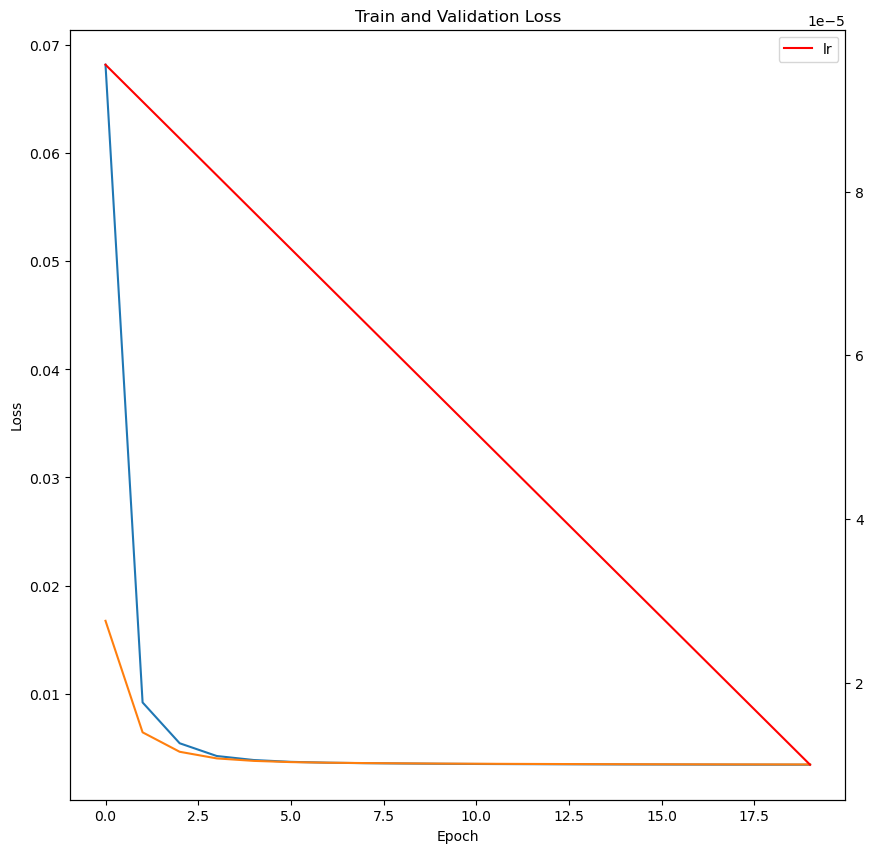

In [22]:
train_loss_array = np.array(train_loss_array)
validation_loss_array = np.array(validation_loss_array)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.plot(range(len(train_loss_array)), train_loss_array, label='train_loss')
ax.plot(range(len(validation_loss_array)), validation_loss_array, label='validation_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

ax2 = ax.twinx()
ax2.plot(range(len(lr_array)), lr_array, label='lr', color='red')

plt.title('Train and Validation Loss')
plt.legend()
plt.show()

In [24]:
df = pd.DataFrame({'Train Loss': train_loss_array, 'Validation Loss': validation_loss_array, 'epoch': epoch_array, 'learning rate': lr_array, 'epoch_duration [s]': time_array})
df.head()

,Train Loss,Validation Loss,epoch,learning rate,epoch_duration [s]
0,0.068199,0.016732,0,0.000096,508.428402
1,0.009179,0.006412,1,0.000091,525.389193
2,0.005400,0.004612,2,0.000087,492.301752
3,0.004221,0.003999,3,0.000082,495.825329
4,0.003848,0.003769,4,0.000077,482.266950


In [25]:
df

,Train Loss,Validation Loss,epoch,learning rate,epoch_duration [s]
0,0.068199,0.016732,0,0.000096,508.428402
1,0.009179,0.006412,1,0.000091,525.389193
2,0.005400,0.004612,2,0.000087,492.301752
3,0.004221,0.003999,3,0.000082,495.825329
4,0.003848,0.003769,4,0.000077,482.266950
5,0.003679,0.003657,5,0.000073,454.487795
6,0.003602,0.003601,6,0.000068,385.893928
7,0.003557,0.003566,7,0.000064,392.289238
8,0.003527,0.003541,8,0.000059,393.833509
9,0.003501,0.003520,9,0.000055,414.426876


# Tesntando o modelo em uma imagem

/var/folders/5z/jvmv1stj4531scvqz47n7cpc0000gn/T/ipykernel_35597/3860515316.py:5: DeprecationWarning: LINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use BILINEAR or Resampling.BILINEAR instead.
  transforms.Resize((1356 // 2, 2028 // 2), interpolation=Image.LINEAR),
/var/folders/5z/jvmv1stj4531scvqz47n7cpc0000gn/T/ipykernel_35597/3860515316.py:7: DeprecationWarning: LINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use BILINEAR or Resampling.BILINEAR instead.
  transforms.Resize((1356, 2028), interpolation=Image.LINEAR)


torch.Size([3, 1356, 2028])
255


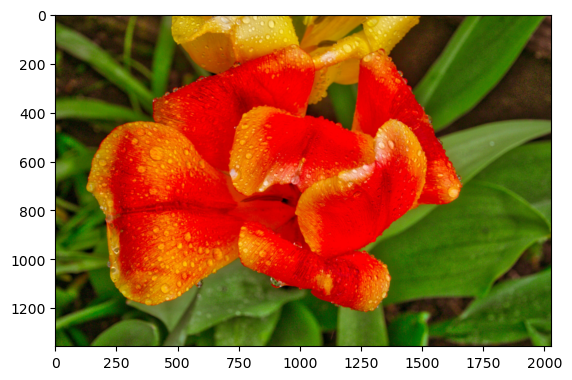

In [10]:
new_image = Image.open(f"{DATASET_ROOT}/Flickr2K/000400.png")
transform = transforms.Compose([
    transforms.ToTensor(),
    # resize image to 33x33 and downsample by BICUBIC interpolation
    transforms.Resize((1356 // 2, 2028 // 2), interpolation=Image.LINEAR),
    # resize image to 256x256
    transforms.Resize((1356, 2028), interpolation=Image.LINEAR)
])


new_image_lr = transform(new_image)
print(new_image_lr.shape)
print(np.array(new_image).max())
image_helper.show_tensor_as_image(new_image_lr) # mudar pro arquivo novo


In [11]:
# new_image.size

In [12]:
# new_image = Image.open(f"{DATASET_ROOT}/Flickr2K/000400.png")
# plt.figure()
# plt.imshow(new_image)
# plt.show()

In [13]:
# import matplotlib.pyplot as plt

# plt.figure()
# new_image_sr = model(new_image_lr.to(device))
# new_image_sr_np = new_image_sr.cpu().detach().numpy()
# # new_img = torch.mul(new_image_sr, 3)
# plt.imshow(new_image_sr_np.transpose((1, 2, 0)))
# plt.show()

NameError: name 'model' is not defined

<Figure size 640x480 with 0 Axes>

In [34]:
# model(torch.randn([3, 33, 33]).to(device))

In [29]:
# abc = torch.mul(new_image_sr, 2)
# abc_np = abc.cpu().detach().numpy()

# abc = new_image_sr
# a = model(new_img)

In [ ]:
# import matplotlib.pyplot as plt

# plt.figure()
# abc = torch.mul(new_image_sr, 0.4)
# abc_np = abc.cpu().detach().numpy()
# plt.imshow(abc_np.transpose((1, 2, 0)))
# plt.show()

In [30]:
# torch.save(model.state_dict(), './srcnn_copiada_no_padding_adam_model.pth')

In [5]:
model_2 = SRCNN(num_channels=3).to(device)
try:
    model_2.load_state_dict(torch.load('./srcnn_copiada_no_padding_adam_model.pth'))
except:
    model_2.load_state_dict(torch.load('./srcnn_copiada_no_padding_adam_model.pth', map_location=torch.device('cpu')))

In [32]:
# df.to_csv('srcnn_copiada_no_padding_adam_model.csv')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


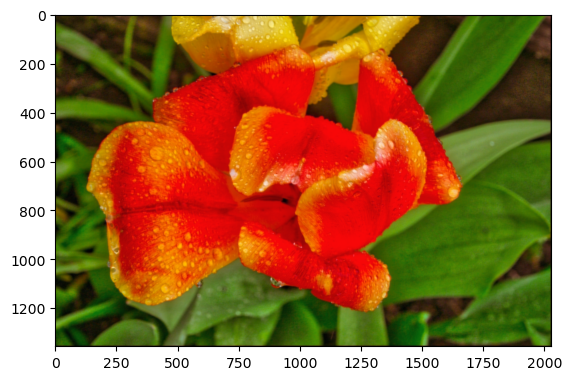

In [15]:
import matplotlib.pyplot as plt

plt.figure()
new_image_sr = model_2(new_image_lr.to(device))
new_image_sr_np = new_image_sr.cpu().detach().numpy()
plt.imshow(new_image_sr_np.transpose((1, 2, 0)))
plt.show()

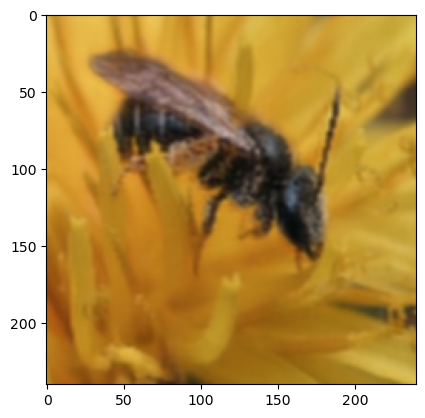

In [35]:
import matplotlib.pyplot as plt

plt.figure()
new_image_sr = model(new_image_lr.to(device))
new_image_sr_np = new_image_sr.cpu().detach().numpy()
# new_img = torch.mul(new_image_sr, 3)
plt.imshow(new_image_sr_np.transpose((1, 2, 0)))
plt.show()